In [1]:
from lorenz_setup import simulate_lorenz

import matplotlib.pyplot as plt

import torch
import numpy as np

from lorenz_settings import (
    N_UNITS,
    MAX_DELAY,
    ALPHA,
    BETA,
    GAMMA,
    DT,
    LMBDA1,
    LMBDA2,
    LMBDA3,
    LMBDA4,
    U_FACTOR,
    W_FACTOR,
)

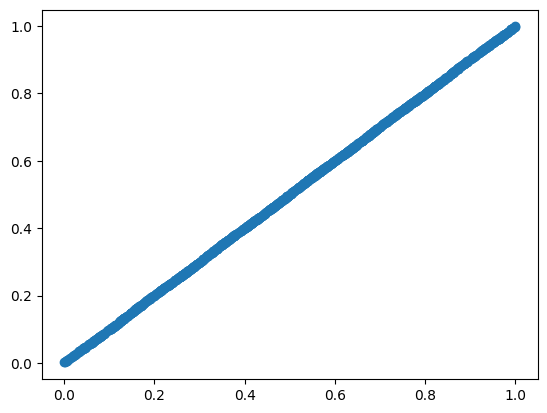

In [2]:
def preprocess_X(X):
    # normalize features to mean 0 and variance 1
    # return (X - X.mean(axis=0)) / np.std(X, axis=0)
    # normalize features to range [0, 1]
    return (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))

def generate_tuning_curves(scalars, dimensions):
    """
    Generate tuning curves as Gaussian curves centered around scalar values.

    Args:
    scalars (ndarray): Array of scalar values between 0 and 1.
    dimensions (int): Number of dimensions in the array.
    width (float): Width of the Gaussian curve.

    Returns:
    tuning_curves (ndarray): Array of N-dimensional arrays representing tuning curves.
    """
    width = 1 / dimensions
    positions = np.linspace(-3 * width, 1 + 3 * width, dimensions)
    tuning_curves = np.exp(
        -((positions[np.newaxis, :] - scalars[:, np.newaxis]) ** 2) / (2 * width**2)
    )
    return tuning_curves


def estimate_scalars_from_tuning_curves(tuning_curves):
    """
    Estimate scalar values from arrays of N-dimensional tuning curves.
    
    Args:
    tuning_curves (ndarray): Array of N-dimensional arrays representing tuning curves.
    width (float): Width of the Gaussian curve used to generate the tuning curves.
    
    Returns:
    estimated_scalars (ndarray): Array of estimated scalar values.
    """
    dimensions = tuning_curves.shape[1]
    width = 1/dimensions
    positions = np.linspace(-3 * width, 1 + 3 * width, dimensions)
    
    # Compute the estimated scalar values for each tuning curve
    tuning_curves = tuning_curves.copy()
    tuning_curves += 1e-6
    tuning_curves = tuning_curves / (tuning_curves.sum(1)[:, np.newaxis])
    estimated_scalars = np.sum(positions * tuning_curves, axis=1) / (np.sum(tuning_curves, axis=1))
    return estimated_scalars


n_units_p = 10

num_samples = 1000
scalar_values = np.random.rand(num_samples)

tuning_curves = generate_tuning_curves(scalar_values, n_units_p)
estimated_scalars = estimate_scalars_from_tuning_curves(tuning_curves)

plt.scatter(scalar_values, estimated_scalars)

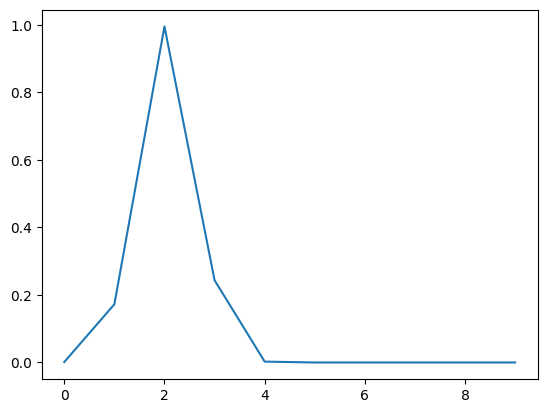

In [3]:
%matplotlib inline
plt.plot(tuning_curves[0])

In [4]:
def get_X(
    sigma=10,
    rho=28,
    beta=8 / 3,
    duration=2000,
    dt=0.01,
    initial_state=[0, 5, 0],
    n_units_p=30,
):
    # Time points
    t = np.arange(0, duration, dt)

    # Simulate the Lorenz system
    X_raw = preprocess_X(simulate_lorenz(t, initial_state, sigma, rho, beta))

    X = np.array([generate_tuning_curves(X_raw[:, i], n_units_p) for i in range(3)])
    return X_raw, np.transpose(X, (1, 0, 2))

In [ ]:
X_raw, X = get_X(duration=40000)

In [5]:
def nonlinearity(x, scale=10, offset=0.5):
    return 1 / (1 + torch.exp(-scale * (x - offset)))

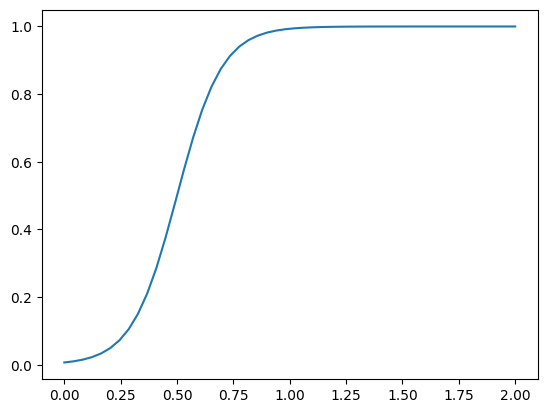

In [6]:
%matplotlib inline
plt.figure()
x = np.linspace(0, 2, 50)
plt.plot(x, nonlinearity(torch.tensor(x)).numpy())

In [7]:
def f_homeostasis(mean_activity, threshold_offset=0.0):
    return max(mean_activity + threshold_offset, 0)

In [8]:
from matplotlib.animation import FuncAnimation


def animate_scatter_and_line(positions, trajectory):
    T, _, N = positions.shape
    M, _ = trajectory.shape

    # Create a figure and 3D axis for the scatter plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")
    scatter = ax.scatter([], [], [], c="b", marker="o")
    (line,) = ax.plot(
        [], [], [], c="r", linewidth=0.5, alpha=0.5
    )  # Static line trajectory

    # Set axis limits
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)

    # Update function for animation
    def update(frame):
        x = positions[frame, 0, :]
        y = positions[frame, 1, :]
        z = positions[frame, 2, :]
        scatter._offsets3d = (x, y, z)

        line.set_data(trajectory[:, 0], trajectory[:, 1])
        line.set_3d_properties(trajectory[:, 2])

        return scatter, line

    # Create the animation
    ani = FuncAnimation(fig, update, frames=T, blit=True, interval=5)
    return fig, ani

In [163]:
def simulate(
    X,
    lmbda1=1,
    lmbda2=6e1,
    n_units=N_UNITS,
    dt=DT,
    alpha=5e2,
    beta_in=5e-4,
    gamma1=1,
    gamma2=2e2,
    target_activity=20/N_UNITS,
    w=None,
):
    device = torch.device(
        "cuda" if torch.cuda.is_available() else "cpu"
    )  # Use GPU if available

    n_steps, n_features, n_units_p = X.shape

    # w = 1 * np.random.randn(n_units, n_features, n_units_p)
    # w -= w.mean()
    if w is None:
        #w = np.random.uniform(0, 0.5, size=(n_units, n_features, n_units_p))**2  # + 0.1
        w = generate_tuning_curves(np.random.rand(n_units * n_features), n_units_p).reshape(n_units,n_features,-1) / 10

    V = torch.zeros((n_steps, n_units), device=device)
    X = torch.from_numpy(X).to(device)
    w = torch.from_numpy(w).to(device)
    slow_a = target_activity * torch.ones(n_units, device=device)
    fast_a = target_activity * torch.ones(n_units, device=device)
    #lateral_inhibition_matrix = (torch.ones(n_units, n_units) - torch.eye(n_units)).to(device) / n_units
    zeros = torch.zeros(n_units, device=device)

    W = []
    W_end = []
    W_mean_hist = []
    W_var_hist = []
    DW_max = []
    Slow_A = []
    Fast_A = []

    for t in range(-5000, 0):
        dv = (
            (
                - V[t - 1]
                + lmbda1 * nonlinearity(
                    torch.einsum("kij,ij->k", w, X[t])
                    + lmbda2 * min(target_activity - fast_a.mean(), 0)
                )
            )
            * dt
            * alpha
        )

        V[t] = V[t - 1] + dv
        slow_a += (V[t] - slow_a) * dt * gamma1
        fast_a += (V[t] - fast_a) * dt * gamma2

    for t in range(n_steps):
        dv = (
            (
                - V[t - 1]
                + lmbda1 * nonlinearity(
                    torch.einsum("kij,ij->k", w, X[t])
                    + lmbda2 * min(target_activity - fast_a.mean(), 0)
                )
            )
            * dt
            * alpha
        )

        V[t] = V[t - 1] + dv

        dw = (
            (
                -2.5e1 * (
                    #(w / w.mean((1, 2))[:, None, None]) *
                    torch.maximum(
                        slow_a - target_activity, zeros
                    )[:, np.newaxis, np.newaxis]
                )
                + torch.einsum("kij,k->kij", (X[None, t] - w), dv / dt + V[t - 1] / dt / alpha)
                - 1.2e2 * w**3
                + 5 * torch.einsum(
                    "kij,k->kij",
                    (X[None, t] - w),
                    torch.maximum(
                        (target_activity - fast_a), zeros
                    )
                    * torch.maximum(
                        (target_activity - slow_a), zeros
                    )
                    # * torch.rand(n_units, device=device)
                )
            )
            * dt
            * beta_in
        )

        w += dw
        w = torch.relu(w)
        slow_a += (V[t] - slow_a) * dt * gamma1
        fast_a += (V[t] - fast_a) * dt * gamma2

        if n_steps - t < 5000:
            W_end.append(w.cpu().numpy())
        if t % 5000 == 0:
            W.append(w.cpu().numpy())

        DW_max.append(dw.abs().max().cpu().item())
        Slow_A.append(slow_a.mean().cpu().item())
        Fast_A.append(fast_a.mean().cpu().item())

    return (
        V.cpu().numpy(),
        w.cpu().numpy(),
        np.array(W),
        slow_a.cpu().numpy(),
        DW_max,
        Slow_A,
        Fast_A,
        W_end
    )

In [64]:
import os

X = np.load("checkpoints/kmeans/X.npy")
X_raw = np.load("checkpoints/kmeans/X_raw.npy")
w_new = np.load("checkpoints/kmeans/w.npy")
W = np.load("checkpoints/kmeans/W.npy")
V = np.load("checkpoints/kmeans/V.npy")

In [84]:
import os

X = np.load("checkpoints/kmeansx/X.npy")
X_raw = np.load("checkpoints/kmeansx/X_raw.npy")
w_new = np.load("checkpoints/kmeansx/w.npy")
W = np.load("checkpoints/kmeansx/W.npy")
V = np.load("checkpoints/kmeansx/V.npy")

In [ ]:
V, w_new, W, a, DW_max, Slow_A, Fast_A, W_end = simulate(X[:4000000], n_units=600)#, w=w_new.copy())

In [ ]:
%matplotlib inline
plt.figure()
plt.plot(((w_new) ** 3).mean((0)).flatten())

In [ ]:
%matplotlib inline
plt.figure()
plt.plot(w_new.mean(0).flatten())

In [ ]:
%matplotlib inline
plt.figure()
plt.imshow(w_new.reshape(-1, 90))

In [ ]:
V[-1000:].max()

In [ ]:
offset = -1
V[offset - 5000 : offset].mean(0).round(3)

In [ ]:
%matplotlib inline
plt.figure()
plt.imshow(V[-5000:].mean(0).round(3).reshape(20, 30))

In [ ]:
%matplotlib inline
plt.figure()
plt.imshow(V[-1].round(3).reshape(20, 30), vmin=0)

In [ ]:
%matplotlib inline
plt.figure()
plt.imshow(X[-100:, 2])

In [ ]:
%matplotlib inline
plt.figure(figsize=(6, 6), dpi=150)
offset = 20000
plt.imshow(V[offset : offset + 100])

In [ ]:
%matplotlib inline
plt.figure(figsize=(6, 6), dpi=150)
plt.imshow(V[-100:])

In [154]:
n_steps, n_features, n_units_p = X.shape

unit_locations_history = np.array(
    [
        [estimate_scalars_from_tuning_curves(w[:, i]) for i in range(n_features)]
        for w in W
    ]
)

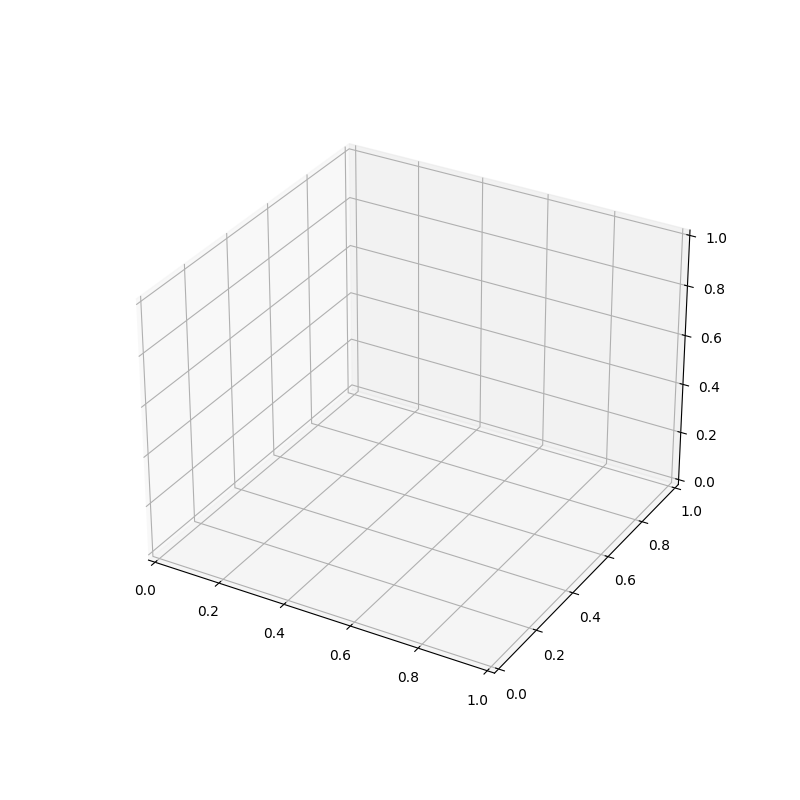

In [155]:
%matplotlib widget
fig, ani = animate_scatter_and_line(unit_locations_history[:350], X_raw[:10000])

In [156]:
plt.close(fig)

In [29]:
unit_locations = np.array([
    X_raw[V[t:t+5000].argmax(0)].T
    for t in range(0, len(V) - 5000, 5000)
])

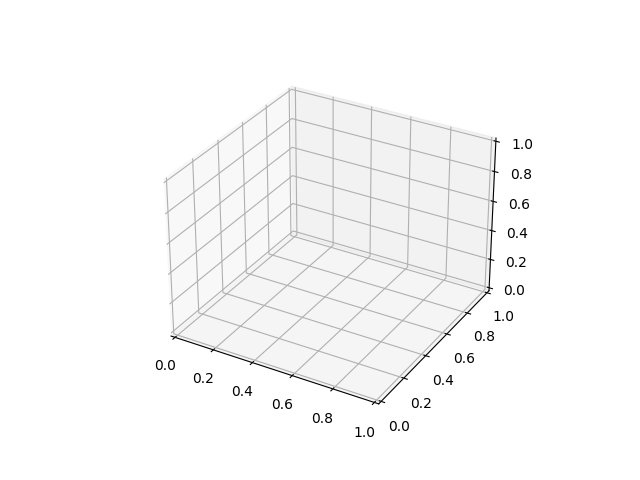

In [30]:
%matplotlib widget
fig, ani = animate_scatter_and_line(unit_locations[:], X_raw[:10000])

In [31]:
plt.close(fig)

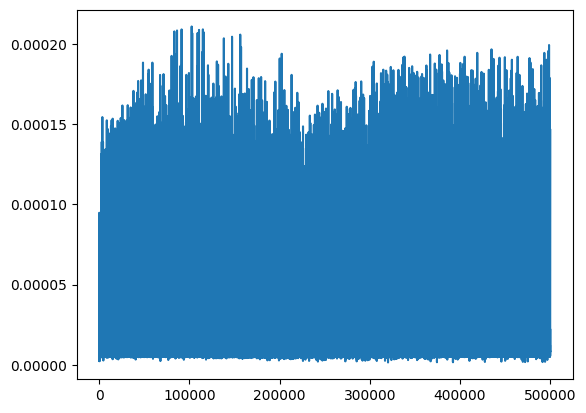

In [44]:
%matplotlib inline
plt.figure()
plt.plot(DW_max[:])

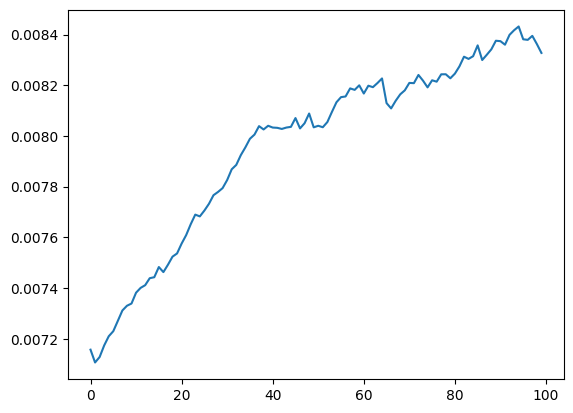

In [45]:
%matplotlib inline
plt.figure()
plt.plot(np.array(W).mean((1, 2, 3)))

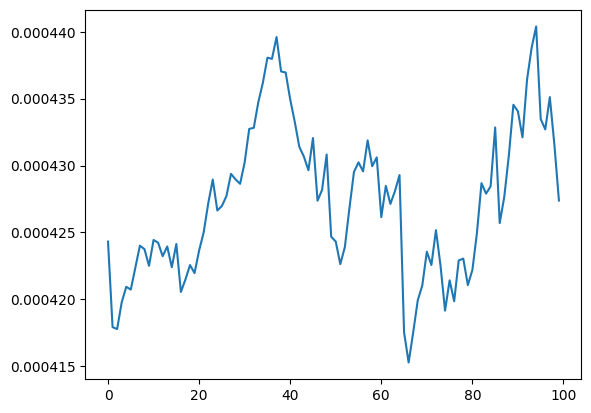

In [46]:
%matplotlib inline
plt.plot(np.array(W).var((1, 2, 3)))

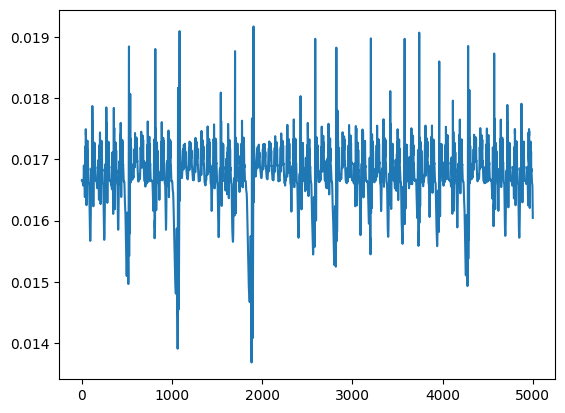

In [47]:
%matplotlib inline
plt.plot(V.mean(1)[-5000:])

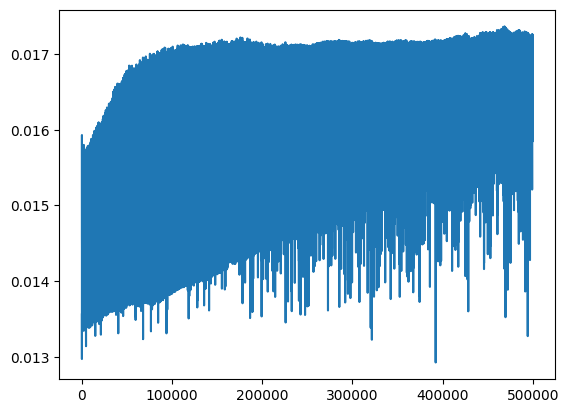

In [48]:
%matplotlib inline
plt.plot(Fast_A[:])

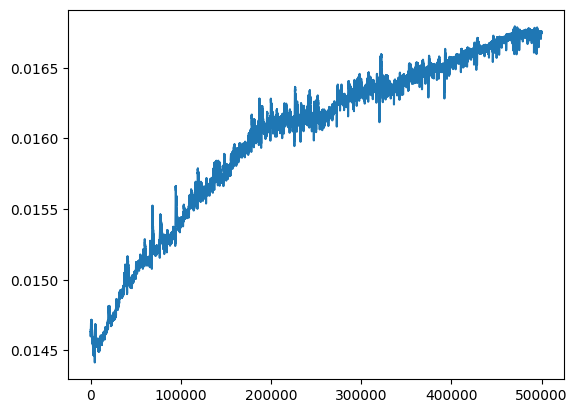

In [49]:
%matplotlib inline
plt.plot(Slow_A[:])

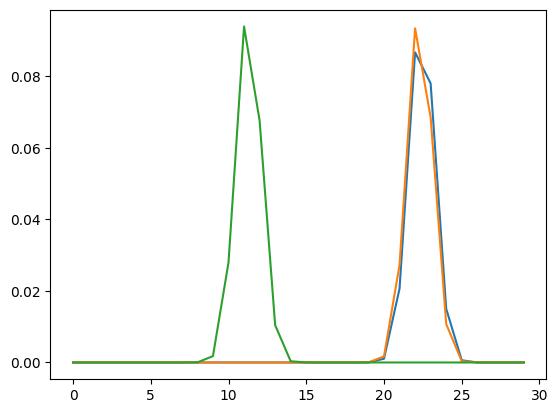

In [128]:
%matplotlib inline
plt.figure()
plt.plot(W[0][3].T)

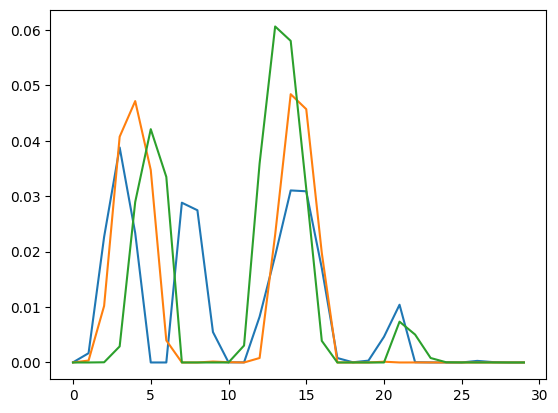

In [139]:
%matplotlib inline
plt.figure()
plt.plot(W[-1][9].T)

(array([48., 98., 65., 59., 67., 86., 97., 53., 21.,  6.]),
 array([0.00883125, 0.01031794, 0.01180464, 0.01329134, 0.01477804,
        0.01626473, 0.01775143, 0.01923813, 0.02072482, 0.02221152,
        0.02369822]),
 <BarContainer object of 10 artists>)

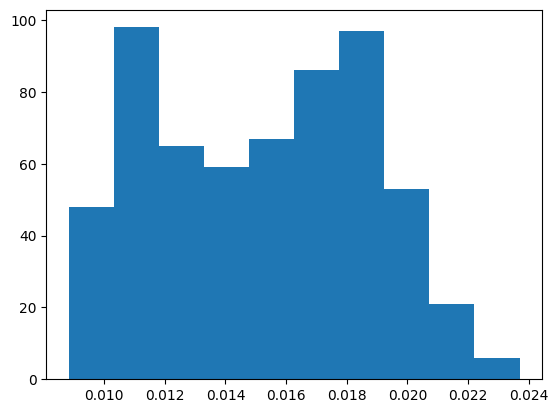

In [123]:
%matplotlib inline
plt.hist(w_new.mean((1, 2)))

(array([  4.,   1.,   1.,   3.,  35.,  66., 212., 188.,  63.,  27.]),
 array([0.01404205, 0.01833148, 0.02262092, 0.02691035, 0.03119978,
        0.03548921, 0.03977865, 0.04406808, 0.04835751, 0.05264694,
        0.05693638]),
 <BarContainer object of 10 artists>)

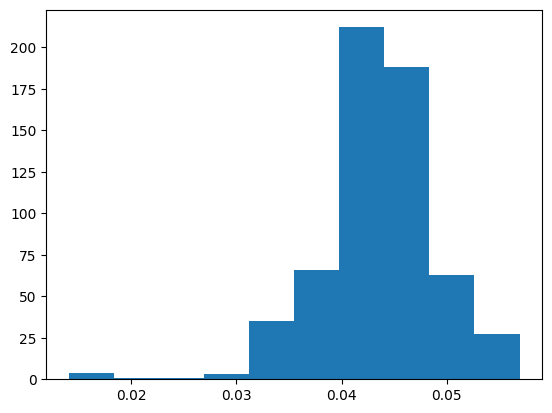

In [124]:
plt.hist(V[-100000:].mean(0))

In [70]:
import os

if not os.path.exists("checkpoints/kmeans"):
    os.makedirs("checkpoints/kmeans")

np.save("checkpoints/kmeans/X.npy", X)
np.save("checkpoints/kmeans/X_raw.npy", X_raw)
np.save("checkpoints/kmeans/w.npy", w_new)
np.save("checkpoints/kmeans/W.npy", W)
np.save("checkpoints/kmeans/V.npy", V)

In [43]:
%matplotlib inline
plt.hist(
    nonlinearity(
        torch.einsum("kij,ij->k", torch.tensor(w), torch.tensor(X[-1]))
        - 8 * f_lateral_inhibition(V[-1 - 1].mean())
    )
)

NameError: name 'w' is not defined

(array([11571668.,   544452.,   357066.,   284386.,   252265.,   242220.,
          246525.,   275304.,   352339.,   873775.]),
 array([0.18242552, 0.24594042, 0.30945531, 0.37297021, 0.4364851 ,
        0.5       , 0.5635149 , 0.62702979, 0.69054469, 0.75405958,
        0.81757448]),
 <BarContainer object of 10 artists>)

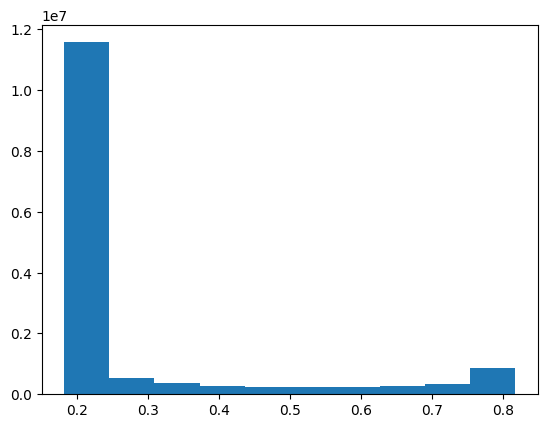

In [161]:
%matplotlib inline
plt.hist(nonlinearity(torch.tensor(X).flatten()).cpu().numpy())

In [ ]:
w.shape

In [ ]:
w_prime = w / w.sum(2)[:, :, np.newaxis]

In [ ]:
plt.plot(w[99, 2])

In [ ]:
plt.plot(w_prime[:3, 2].T)

In [ ]:
plt.plot(tuning_curves[:4].T);

In [ ]:
unit_locations_history.shape

In [241]:
unit_locations = np.array(
    [estimate_scalars_from_tuning_curves(w[:, i]) for i in range(n_features)]
)

In [242]:
unit_locations.max()

1.2166318837117882

In [251]:
unit_locations.shape

(3, 100)

In [243]:
unit_locations.min()

-0.2896282954398167

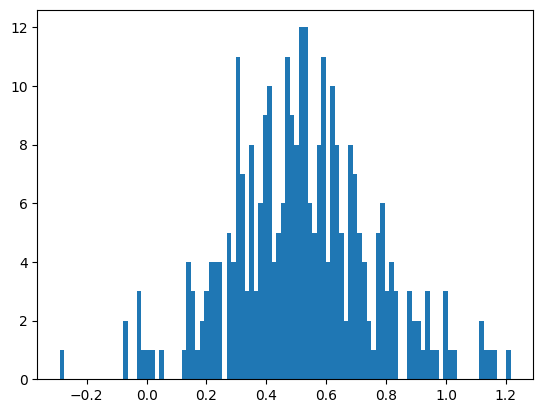

In [244]:
plt.hist(unit_locations.flatten(), bins=100);  # plt.xlim(-5, 6)

In [157]:
n_steps, n_features, n_units_p = X.shape

unit_locations_history = np.array(
    [
        [estimate_scalars_from_tuning_curves(w[:, i]) for i in range(n_features)]
        for w in W
    ]
)

In [158]:
def animate_ax1(positions, X, V):
    T = len(V)

    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122, projection='3d')

    scatter = ax2.scatter(*positions, c=[], marker='o')
    #line = ax2.plot([], [], [], c='b', linewidth=0.5, alpha=0.5)

    unit_scatter1 = ax1.scatter([0]*len(input_coords), input_coords, cmap='viridis', c=X[0].flatten(), s=3e1)
    unit_scatter2 = ax1.scatter([0.5]*len(hidden_coords), hidden_coords, cmap='viridis', c=V[0], s=2e1)#, alpha=[])

    ax1.set_xticks([])
    ax1.set_yticks([])

    # Update function for animation
    def update(frame):
        #x = positions[min(frame, len(positions) - 1), 0, :]
        #y = positions[min(frame, len(positions) - 1), 1, :]
        #z = positions[min(frame, len(positions) - 1), 2, :]
        #scatter._offsets3d = (x, y, z)
        scatter.set_array(V[frame])
        #scatter.set_alpha(np.minimum(20 * V[frame]**1, 1))
        
        unit_scatter1.set_array(X[frame].flatten())
        unit_scatter2.set_array(V[frame])
        unit_scatter2.set_alpha(np.minimum(5 * V[frame], 1))

        return unit_scatter1, unit_scatter2

    # Create the animation
    ani = FuncAnimation(fig, update, frames=T, blit=True, interval=1)
    return fig, ani

In [159]:
def adjust_coordinates(coordinates, gap, group_size):
    adjusted_coordinates = []
    for idx, coord in enumerate(coordinates):
        offset = idx // group_size * gap
        adjusted_coordinates.append(coord + offset)
    return np.array(adjusted_coordinates)

gap = 10
group_size = 30

input_coords = (200 / 80) * adjust_coordinates(list(range(3*group_size)), gap, group_size)
hidden_coords = np.array(list(range(600)))

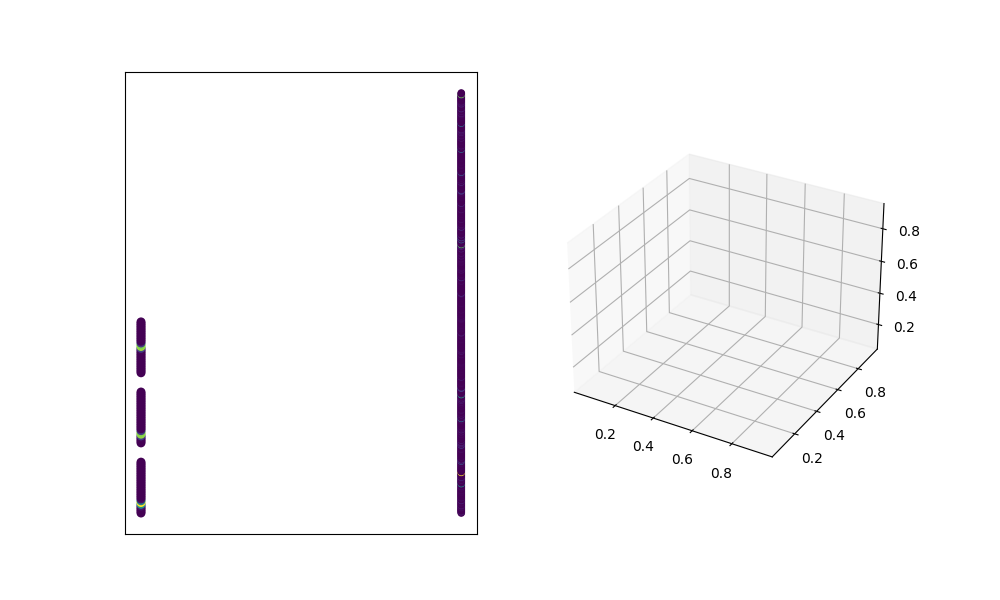

In [160]:
%matplotlib widget
fig, ani = animate_ax1(X_raw[V[-50000:].argmax(0)].T, X[-4999:], V[-4999:])

In [458]:
import matplotlib.animation as animation

ani.save("kmeans_activations.mp4", writer=animation.FFMpegWriter(fps=60))

In [161]:
plt.close(fig)

In [522]:
W = np.array(W)

In [523]:
DW = W[1:] - W[:-1]

In [524]:
np.abs(DW).mean((2, 3)).argmax(keepdims=False)

5477

In [525]:
DW.shape

(5999, 200, 3, 20)

In [526]:
A = DW.max((2, 3))

In [527]:
np.unravel_index(np.abs(A).argmax(), A.shape)

(27, 77)

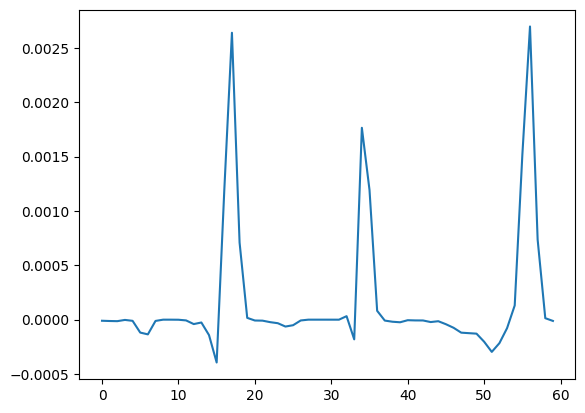

In [528]:
%matplotlib inline
plt.figure()
plt.plot(DW[27, 77].flatten())

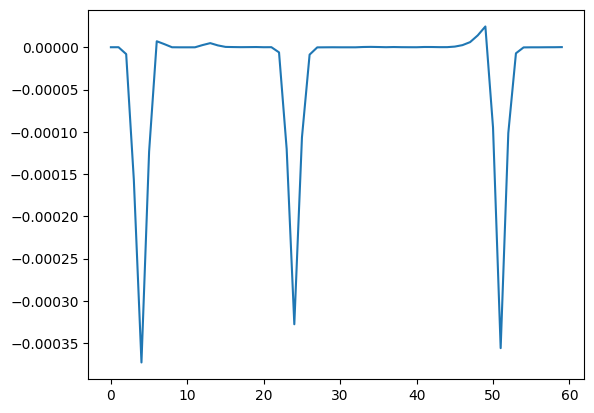

In [529]:
%matplotlib inline
plt.figure()
plt.plot(DW[1810, 66].flatten())

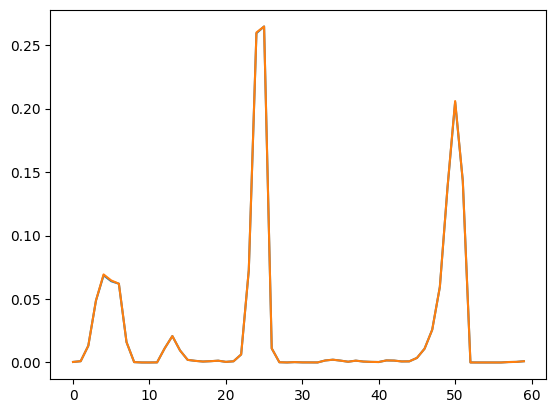

In [530]:
%matplotlib inline
plt.figure()
plt.plot(W[1808, 66].flatten())
plt.plot(W[1811, 66].flatten())

In [531]:
DL = unit_locations_history[1:] - unit_locations_history[:-1]

In [532]:
np.unravel_index(np.abs(DL).argmax(), DL.shape)

(24, 1, 81)

In [533]:
unit_locations_history[27, 1, 40]

0.23743414452591635

In [534]:
unit_locations_history.shape

(6000, 3, 200)

In [535]:
W[2, 66, 0]

array([4.45581057e-04, 1.09645685e-03, 1.46065988e-02, 5.68970812e-02,
       9.13561507e-02, 7.57469676e-02, 4.46458705e-02, 5.06091384e-03,
       1.38947569e-06, 9.77637918e-06, 1.05574443e-05, 1.00097487e-04,
       1.23984624e-02, 2.29419424e-02, 1.04258154e-02, 2.12903333e-03,
       1.38553737e-03, 9.65288883e-04, 1.14240938e-03, 1.55301945e-03])

In [536]:
DL[2, 0, 66]

-1.8143121758212866e-05